The objective of this assignment is to scrape consumer reviews from a set of web
pages and to evaluate the performance of text classification algorithms on the data.
The reviews have been divided into seven categories here:
http://mlg.ucd.ie/modules/yalp
Each review has a star rating. For this assignment, we will assume that 1-star to
3-star reviews are “negative”, and 4-star to 5-star reviews are “positive”.
The assignment should be implemented as a single Jupyter Notebook (not a script).
Your notebook should be clearly documented, using comments and Markdown cells to
explain the code and results.


##### 1. Select three review categories of your choice. Scrape all reviews for each category and store them as three separate datasets. For each review, you should store the review text and a class label (i.e. whether the review is “positive” or “negative”).


#### Using Beautiful soup

In [1]:
import pandas as pd
import numpy as np

Setting up a connection with the webpage to scrape from, 'http://mlg.ucd.ie/modules/yalp/'.

Then using the BeautifulSoup Package along with requests to strip the category names from the website.

In [2]:
import requests
cats = []

link = 'http://mlg.ucd.ie/modules/yalp/'
r = requests.get(link)
if r.status_code == 200:
    html = r.content

import bs4 # importing the beautiful soup module
parser = bs4.BeautifulSoup(html,'html.parser') 
for match in parser.find_all('h4'): #Finds all sub headings with label h4 in HTML
    text = match.get_text(strip = True) #strip = True removes unicode characters
    print(text)
    start = text.find(': ') + 2
    end  = text.find("(")

    cats.append(text[start:end])
    

Category: Automotive(132 businesses)
Category: Cafes(96 businesses)
Category: Fashion(159 businesses)
Category: Gym(122 businesses)
Category: Hair and Salons(143 businesses)
Category: Hotels(113 businesses)
Category: Restaurants(100 businesses)


Confirming the Categories have been Added to the cats list correctly

In [3]:
cats

['Automotive',
 'Cafes',
 'Fashion',
 'Gym',
 'Hair and Salons',
 'Hotels',
 'Restaurants']

Getting the link to each category's website where you can access their review data.

In [4]:
links = []
parser = bs4.BeautifulSoup(html,'html.parser')
for match in parser.find_all('a'): # a's in html contain links
    lk = match.get('href') #finding all links that have the tag href
    if lk != 'index.html':
        links.append(link  + lk) #adding each link to a list of links
    
links_dict = dict(zip(cats,links)) # making a dictionary of the links for each genre
links_dict

{'Automotive': 'http://mlg.ucd.ie/modules/yalp/automotive_list.html',
 'Cafes': 'http://mlg.ucd.ie/modules/yalp/cafes_list.html',
 'Fashion': 'http://mlg.ucd.ie/modules/yalp/fashion_list.html',
 'Gym': 'http://mlg.ucd.ie/modules/yalp/gym_list.html',
 'Hair and Salons': 'http://mlg.ucd.ie/modules/yalp/hair_salons_list.html',
 'Hotels': 'http://mlg.ucd.ie/modules/yalp/hotels_list.html',
 'Restaurants': 'http://mlg.ucd.ie/modules/yalp/restaurants_list.html'}

The get_review_data function gets review data on company name, State, Star Rating and review text for 
a given category

It returns the data in a Pandas DataFrame object

In [5]:
def get_review_data(category): # gets review data for a certain category
    links = []
    linky = links_dict[category]
    r = requests.get(linky)
    if r.status_code == 200:
        html = r.content

    parser = bs4.BeautifulSoup(html,'html.parser')

    for match in parser.find_all('a'):
        lk = match.get('href')
        if lk != 'index.html':
            links.append(link + lk)
            
    company_name = []
    review_state = []
    review_texts = []
    review_stars = []
            
    for linky in links:
        r = requests.get(linky)
        if r.status_code == 200:
            html = r.content
        parser = bs4.BeautifulSoup(html,'html.parser')

        for lineo in parser.find_all('p', class_ = 'review-text'): # gets the review text
            review_texts.append(lineo.text)

        for lineo in parser.find_all('p', class_ = 'rating'): # gets number of stars
            review_stars.append(lineo.img.get('alt').strip())
            review_state.append(parser.find_all('p', class_ = 'details')[0].get_text()[-2:]) # gets the review state(i.e. location)
            company_name.append(parser.find('h3').text.strip('Yalp — ')) #gets the company name
    
    df = pd.DataFrame({'Company':company_name , 'State':review_state, 'Stars':review_stars, 'Review':review_texts})
    df['Rating'] = np.where((df['Stars'] == '5-star') |(df['Stars'] == '4-star'),'Positive','Negative') # converting stars to postive or negative
    return df


The idea behind getting the company name and state is that it may be useful to have
them if you wanted to build a classifer using more than just the review data.

Storing the downloaded data for each chosen category in CSV format for safekeeping

In [6]:
picks = ['Automotive','Gym','Hotels']
for pick in picks:
    get_review_data(pick).to_csv(pick+'_review_data.csv',index = False)

In [7]:
auto = pd.read_csv('Automotive_review_data.csv')
gym = pd.read_csv('Gym_review_data.csv')
hotel = pd.read_csv('Hotels_review_data.csv')

Loading the data back up from the CSV Files

In [8]:
hotel.head()

,Company,State,Stars,Review,Rating
0,'Round Table Tours,QC,5-star,Melissa took us on a tour of Asia in the space...,Positive
1,'Round Table Tours,QC,5-star,With a group of seven of us visiting Montreal ...,Positive
2,'Round Table Tours,QC,5-star,Melissa is a gem! My fiancé found her tour on ...,Positive
3,'Round Table Tours,QC,5-star,A perfect day in Montreal! Melissa outfitted u...,Positive
4,'Round Table Tours,QC,5-star,I had a really great food truck tour with Meli...,Positive


Printing the first five rows of 'hotels' to verify the data has been scraped, saved and loaded correctly.

#### 2. For each of the three category datasets:

##### a. From the reviews in this category, apply appropriate preprocessing steps to create a numeric representation of the data, suitable for classification.



In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer


def text_preprocesser(data, fiton): # fiton specifies what data to fit the pre processor on
    documents = pd.DataFrame(data['Review'])
    
    #removing numbers
    documents['Review'] = documents['Review'].str.replace(r'\d+','')
    
    #Make the review data Lower case
    documents['Review'] = documents['Review'].str.lower()
    
    #Filtering out stop words
    vectorizer = CountVectorizer(stop_words = 'english')
    tokenize = vectorizer.build_tokenizer()
    documents['Review'] = documents['Review'].apply(tokenize)
    
    #Stemming the text data
    stemmer = SnowballStemmer('english') # snowball stemmer is said to be better than PorterStemmer
    documents['Review'] = documents['Review'].apply(lambda x: [stemmer.stem(y) for y in x])
    
    #Lemmatizing the data
    lemmatizer = WordNetLemmatizer()
    documents['Review'] = documents['Review'].apply(lambda x: [lemmatizer.lemmatize(y,'v') for y in x])
    documents['Review'] = documents['Review'].apply(lambda x:' '.join([str(elm) for elm in x]))

    #Performing TfidfVectorization
    vectorizer = TfidfVectorizer(sublinear_tf = True,min_df = 5,
                                 encoding = 'latin-1',ngram_range = (1,2),stop_words = 'english')
    
    vectorizer = vectorizer.fit(fiton['Review'])
    X = vectorizer.transform(documents['Review'])
    
    df = pd.DataFrame(X.todense(), columns = vectorizer.get_feature_names())
    return df
    
    

The text_preprocessor function turns raw text data into a Document Term matrix suitable for
feeding into classifier objects.

Text Preprocessing is an important step in the overall model building process.
Text data is unstructured, which means it is very diffiult for ordinary classification 
Algorithms to accuractely model it without some preprocessing done first.

We remove numbers as they usually are not relevant to the overall sentiment of a text data cell,
and hence just serve to add noise and reduce accuracy. 
The same can be said for symbols like £$%^ which are filtered out

Filtering out stop words is important. Stop words are words like 'and' , 'as' , 'it' etc 
and are the most common words in the english language. Leaving them in would only serve to reduce accuracy because all reviews are likely to have a lot of these words, making it appear to the classification algorithm that reviews are more similar than they actually are.

Stemming just removes or stems the last few characters of a word.
Lemmatization considers the context and converts the word to its meaningful base form.

They are important as a word such as cycled and cycle would appear to be completely different words to a classification algortihm, but stemming and lemmatizing would convert both to something like cycl, which helps increase classification accuracy as they now share a common word.

Tfidf vectorization puts a weight on each word and also creates word pairs for each word in the text data.


Details on snowball stemmer: https://www.nltk.org/howto/stem.html



In [10]:
cats = (auto,gym,hotel)
cats_dict = dict(zip(picks,cats))

for cat in cats_dict.keys():
    text_preprocesser(cats_dict[cat],cats_dict[cat]).to_csv(cat+'_preprocessed_review_data.csv',index = False)
    

Writing the data to CSV files for safekeeping

In [11]:
auto_pp = pd.read_csv('Automotive_preprocessed_review_data.csv')
gym_pp = pd.read_csv('Gym_preprocessed_review_data.csv')
hotel_pp = pd.read_csv('Hotels_preprocessed_review_data.csv')

datasets = (auto_pp,gym_pp,hotel_pp)

##### b. Build a classification model to distinguish between “positive” and “negative” reviews using one of the following classifiers: Naive Bayes, Logistic Regression, Random Forests



In [12]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score


def bias(y_test,y_pred):
    min_class = Counter(y_test).most_common()[-1][0]
    return Counter(y_pred)[min_class]/Counter(y_test)[min_class] 


Defining a Function for estimating Bias.
Bias is when a Machine Learning Algorithm Under predicts a minority class due to it having a 
relitvely low count compared to the majority class.

In [14]:
def simulate_cross_val(num_sims,models, X, y):
    
    acc = np.zeros((num_sims, len(models)))
    f1 = np.zeros((num_sims, len(models)))
    bias_scores = np.zeros((num_sims, len(models)))
    
    scoring = {'accuracy':make_scorer(accuracy_score) , 'bias' : make_scorer(bias),
              'f1-score':make_scorer(f1_score)}
    
    cv = KFold(n_splits = 10, shuffle = True)
    
    for i in range(num_sims):
        j = 0
        for model in models:
            scores = cross_validate(model,X,y,scoring = scoring , cv = cv)
            acc[i,j] = np.mean(scores['test_accuracy'])
            f1[i,j] = np.mean(scores['test_f1-score'])
            bias_scores[i,j] = np.mean(scores['test_bias'])
            
            j += 1
    store = pd.DataFrame(columns = [type(m).__name__ for m in models])
    store.loc['Accuracy',:] = np.mean(acc,axis = 0)
    store.loc['f1-score',:] = np.mean(f1,axis = 0)
    store.loc['Bias',:] = np.mean(bias_scores,axis = 0)
    store.sort_values(by = 'Accuracy', axis = 1, ascending = False, inplace = True)
    
    return store

simulate_cross_val caluclates the accuracy, F1 and Bias scores for a given set of input classifiers.

It simulates k fold cross validation a given number of times(num_sims) and gets the
average of the cross validation scores.

This produces more stable estimates for the scores, as one score on its own is more 
volatile than the mean of a large number of runs(approx 50).

##### c. Test the predictions of the classification model using an appropriate evaluation strategy. Report and discuss the evaluation results in your notebook.

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder

mnb = MultinomialNB()
gnb = GaussianNB()
bnb = BernoulliNB()
lreg = LogisticRegression(solver = 'lbfgs')
rf = RandomForestClassifier()
models = (mnb,gnb,bnb,lreg,rf)


******************************
*******    Automotive  *******
******************************
         LogisticRegression RandomForestClassifier MultinomialNB BernoulliNB  \
Accuracy            0.88885                 0.8558        0.8478      0.8181   
f1-score           0.910279               0.884472      0.884766    0.858586   
Bias                0.92512               0.900732      0.714563    0.804705   

         GaussianNB  
Accuracy    0.77285  
f1-score   0.801202  
Bias        1.17348  


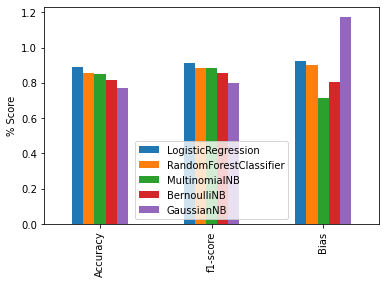

******************************
*******    Gym  *******
******************************
         LogisticRegression RandomForestClassifier BernoulliNB MultinomialNB  \
Accuracy            0.88865                0.86705      0.8487       0.84605   
f1-score           0.917577               0.902832    0.888033      0.892577   
Bias               0.838068               0.788842     0.83964       0.60561   

         GaussianNB  
Accuracy     0.7269  
f1-score   0.762131  
Bias        1.43314  


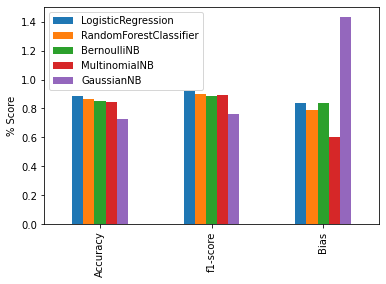

******************************
*******    Hotels  *******
******************************
         LogisticRegression RandomForestClassifier MultinomialNB BernoulliNB  \
Accuracy             0.8829                0.86475        0.8517     0.82315   
f1-score           0.903951               0.889185       0.88371    0.858707   
Bias               0.885285               0.881548      0.749123    0.811391   

         GaussianNB  
Accuracy      0.705  
f1-score   0.716682  
Bias        1.32317  


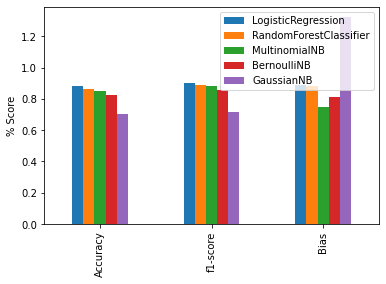

In [16]:
import matplotlib.pyplot as plt

i = 0
for dataset in datasets:
    print('*' *20)
    print('***',picks[i],'***' )
    print('*'*20)
    X = dataset.values
    y = cats[i]['Rating']
    y = np.where(y == 'Positive',1,0)
    scv = simulate_cross_val(10,models,X,y)
    print(scv)
    scv.plot.bar()
    plt.ylabel('% Score')
    plt.show()
    i += 1


Here 20 simulations are run for each cross fold. Running more simulations increases the accuracy
of the accuracy, bias and f1 scores as they are an average not a single value.

Increasing the number of simulations comes at a cost of longer computational time.

Logistic regression is chosen as the classifier for all 3 of 'Automotive', 'Gym' and 'Hotel' as it has the highest accuracy and f1 scores, as well as a bias score closest to one in general.

The bias scores should be near 1. The closer to 1 it is, the better the classifier is at predicting the correct amount of minority class correctly.

As all the bias scores are quite close to 1, it is not given much consideration in selecting classifers - accuracy is more important in this case.
I

F1 score, the harmonic mean of precision and recall, could also be used to choose the most appropriate classifier.
In this case there would be no difference in selecting models based on F1 or accuracy score


### 3. Evaluate the performance of each of your three classification models when applied to data from the other two selected categories. That is, for the selected categories (A,B,C), run the experiments:

#### a. Train a classification model on the data from “Category A”. 
Evaluate its performance on data from “Category B” and data from “Category C”.
#### b. Train a classification model on the data from “Category B”. 
Evaluate its performance on data from “Category A” and data from “Category C”.
#### c. Train a classification model on the data from “Category C”. 
Evaluate its performance on data from “Category A” and data from “Category B”.

In [17]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
print('Category A: ', picks[0])
print('Category B: ', picks[1])
print('Category C: ', picks[2])
print()

chosen_models = (lreg,lreg,lreg)
models_dict = dict(zip(picks,chosen_models))

results = np.array((2*len(datasets),4))
i = 0

rocs = pd.DataFrame(index = ['fpr','tpr'])

for i in range(len(datasets)):
    X = datasets[i].values
    y = cats[i]['Rating']
    y = np.where(y == 'Positive',1,0)
    
    for j in [1,2]:
        
        clf = models_dict[picks[i]].fit(X,y)
        predict_data = text_preprocesser(cats[i-j], fiton = cats[i]) # creating a matrix of vector terms, fitting on the train data and transforming the test data
        y1 = np.where(cats[i-j]['Rating'] == 'Positive',1,0)
        
        y_pred = clf.predict(predict_data)
        y_score = clf.predict_proba(predict_data) # Propabilities for the ROC Curve
        
        fpr, tpr, t = roc_curve(y1, y_score[:,1]) # calculating false positive and false negative rates
        rocs[picks[i] + ' on ' + picks[i-j]] = [fpr,tpr]
        
        print('Accuracy,F1 Score of',picks[i],'training data on ', picks[i-j],': ', round(100*accuracy_score(y1,y_pred),1),'%,', round(100*f1_score(y1,y_pred),1),'%')
    
    

Category A:  Automotive
Category B:  Gym
Category C:  Hotels

Accuracy,F1 Score of Automotive training data on  Hotels :  84.1 %, 87.1 %
Accuracy,F1 Score of Automotive training data on  Gym :  85.2 %, 89.2 %
Accuracy,F1 Score of Gym training data on  Automotive :  82.2 %, 84.4 %
Accuracy,F1 Score of Gym training data on  Hotels :  83.7 %, 85.9 %
Accuracy,F1 Score of Hotels training data on  Gym :  86.8 %, 90.2 %
Accuracy,F1 Score of Hotels training data on  Automotive :  86.1 %, 88.0 %


The ability of the classifiers to predict unseen data is tested here.

We see that all the classifiers from each dataset produce high degrees of accuracy, with an average of ~85%
The F1-Scores are also high showing the model has good precision and recall scores as well.



In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y1,y_pred)

array([[ 700,   88],
       [ 191, 1021]], dtype=int64)

Plotting a confusion matrix for  Hotels training data on  Automotive

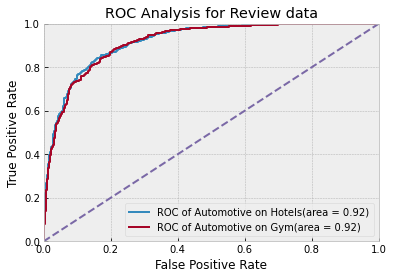

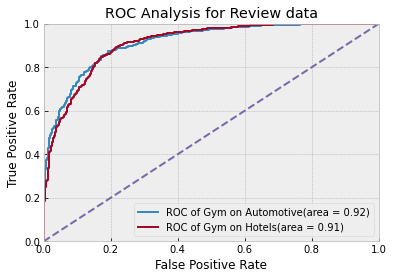

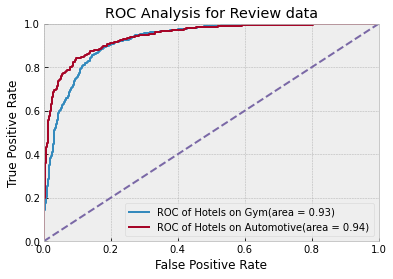

In [19]:
import matplotlib as mpl
mpl.style.use('bmh')
def plot_ROC(df,no_plots):
    count = 0
    for i in range(0,no_plots*2,2):

        fpr = df.iloc[0,i]
        tpr = df.iloc[1,i]

        plt.figure()
        lw = 2
        plt.plot(fpr, tpr,
                 lw=lw, label='ROC of ' + df.columns[count] + '(area = %0.2f)' % auc(fpr, tpr))
        count += 1

        fpr = df.iloc[0,i+1]
        tpr = df.iloc[1,i+1]
    
        plt.plot(fpr, tpr,
                 lw=lw, label= 'ROC of ' + df.columns[count] + '(area = %0.2f)' % auc(fpr, tpr))
        count += 1

        plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Analysis for Review data')
        plt.legend(loc="lower right")
        plt.show()
        
plot_ROC(rocs,3)

ROC Curves are a effective method of analysing the performance of a classification result. 

The closer to the upper left hand corner of the plot the red/blue lines are, the better fit to the data they provide.
The dotted line shows the ROC of a random selection process.

It is clear from the above plots our classifiers do a good job of prediciting unseen data.

The higher the AUC(area under curve), the better the fit.
We see here that the ROC AUC values all have a value close to 1, meaning that the models fit the data well.



##### Conclusion

With the right preprocessing, we can build very accurate models to predict the sentiment of reviews from the Yelp! website.

It appears that reviewers generally use the same core words or pairs of words when leaving reviews.

We see that the genre of service, whether it is auto, gym or hotels does't make much difference in the predictive power 
of the data - we can predict other genres with a high level of accuracy. 

